### ２つの画像の差（増えたところと減ったところ）を抽出する処理ステップ

次の２つのファイル(src1:画像１とsrc2:画像２)を比較

In [3]:
src1="images/figa1.jpg"
src2="images/figa2.jpg"

使用するパッケージ

In [4]:
import os, sys
import cv2
import numpy as np

opencvに画像ファイルを読み込む関数

In [5]:
def read(path) :
    img = cv2.imread(path)
    return img

opencvの画像データをjupyterにインライン表示する関数

In [6]:
from IPython.display import display, Image

def disp(image, format='.png'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(Image(data=decoded_bytes))

比較対象ファイルを読み込み

In [7]:
fig1 = read(src1)
fig2 = read(src2)

画像1,画像2を表示

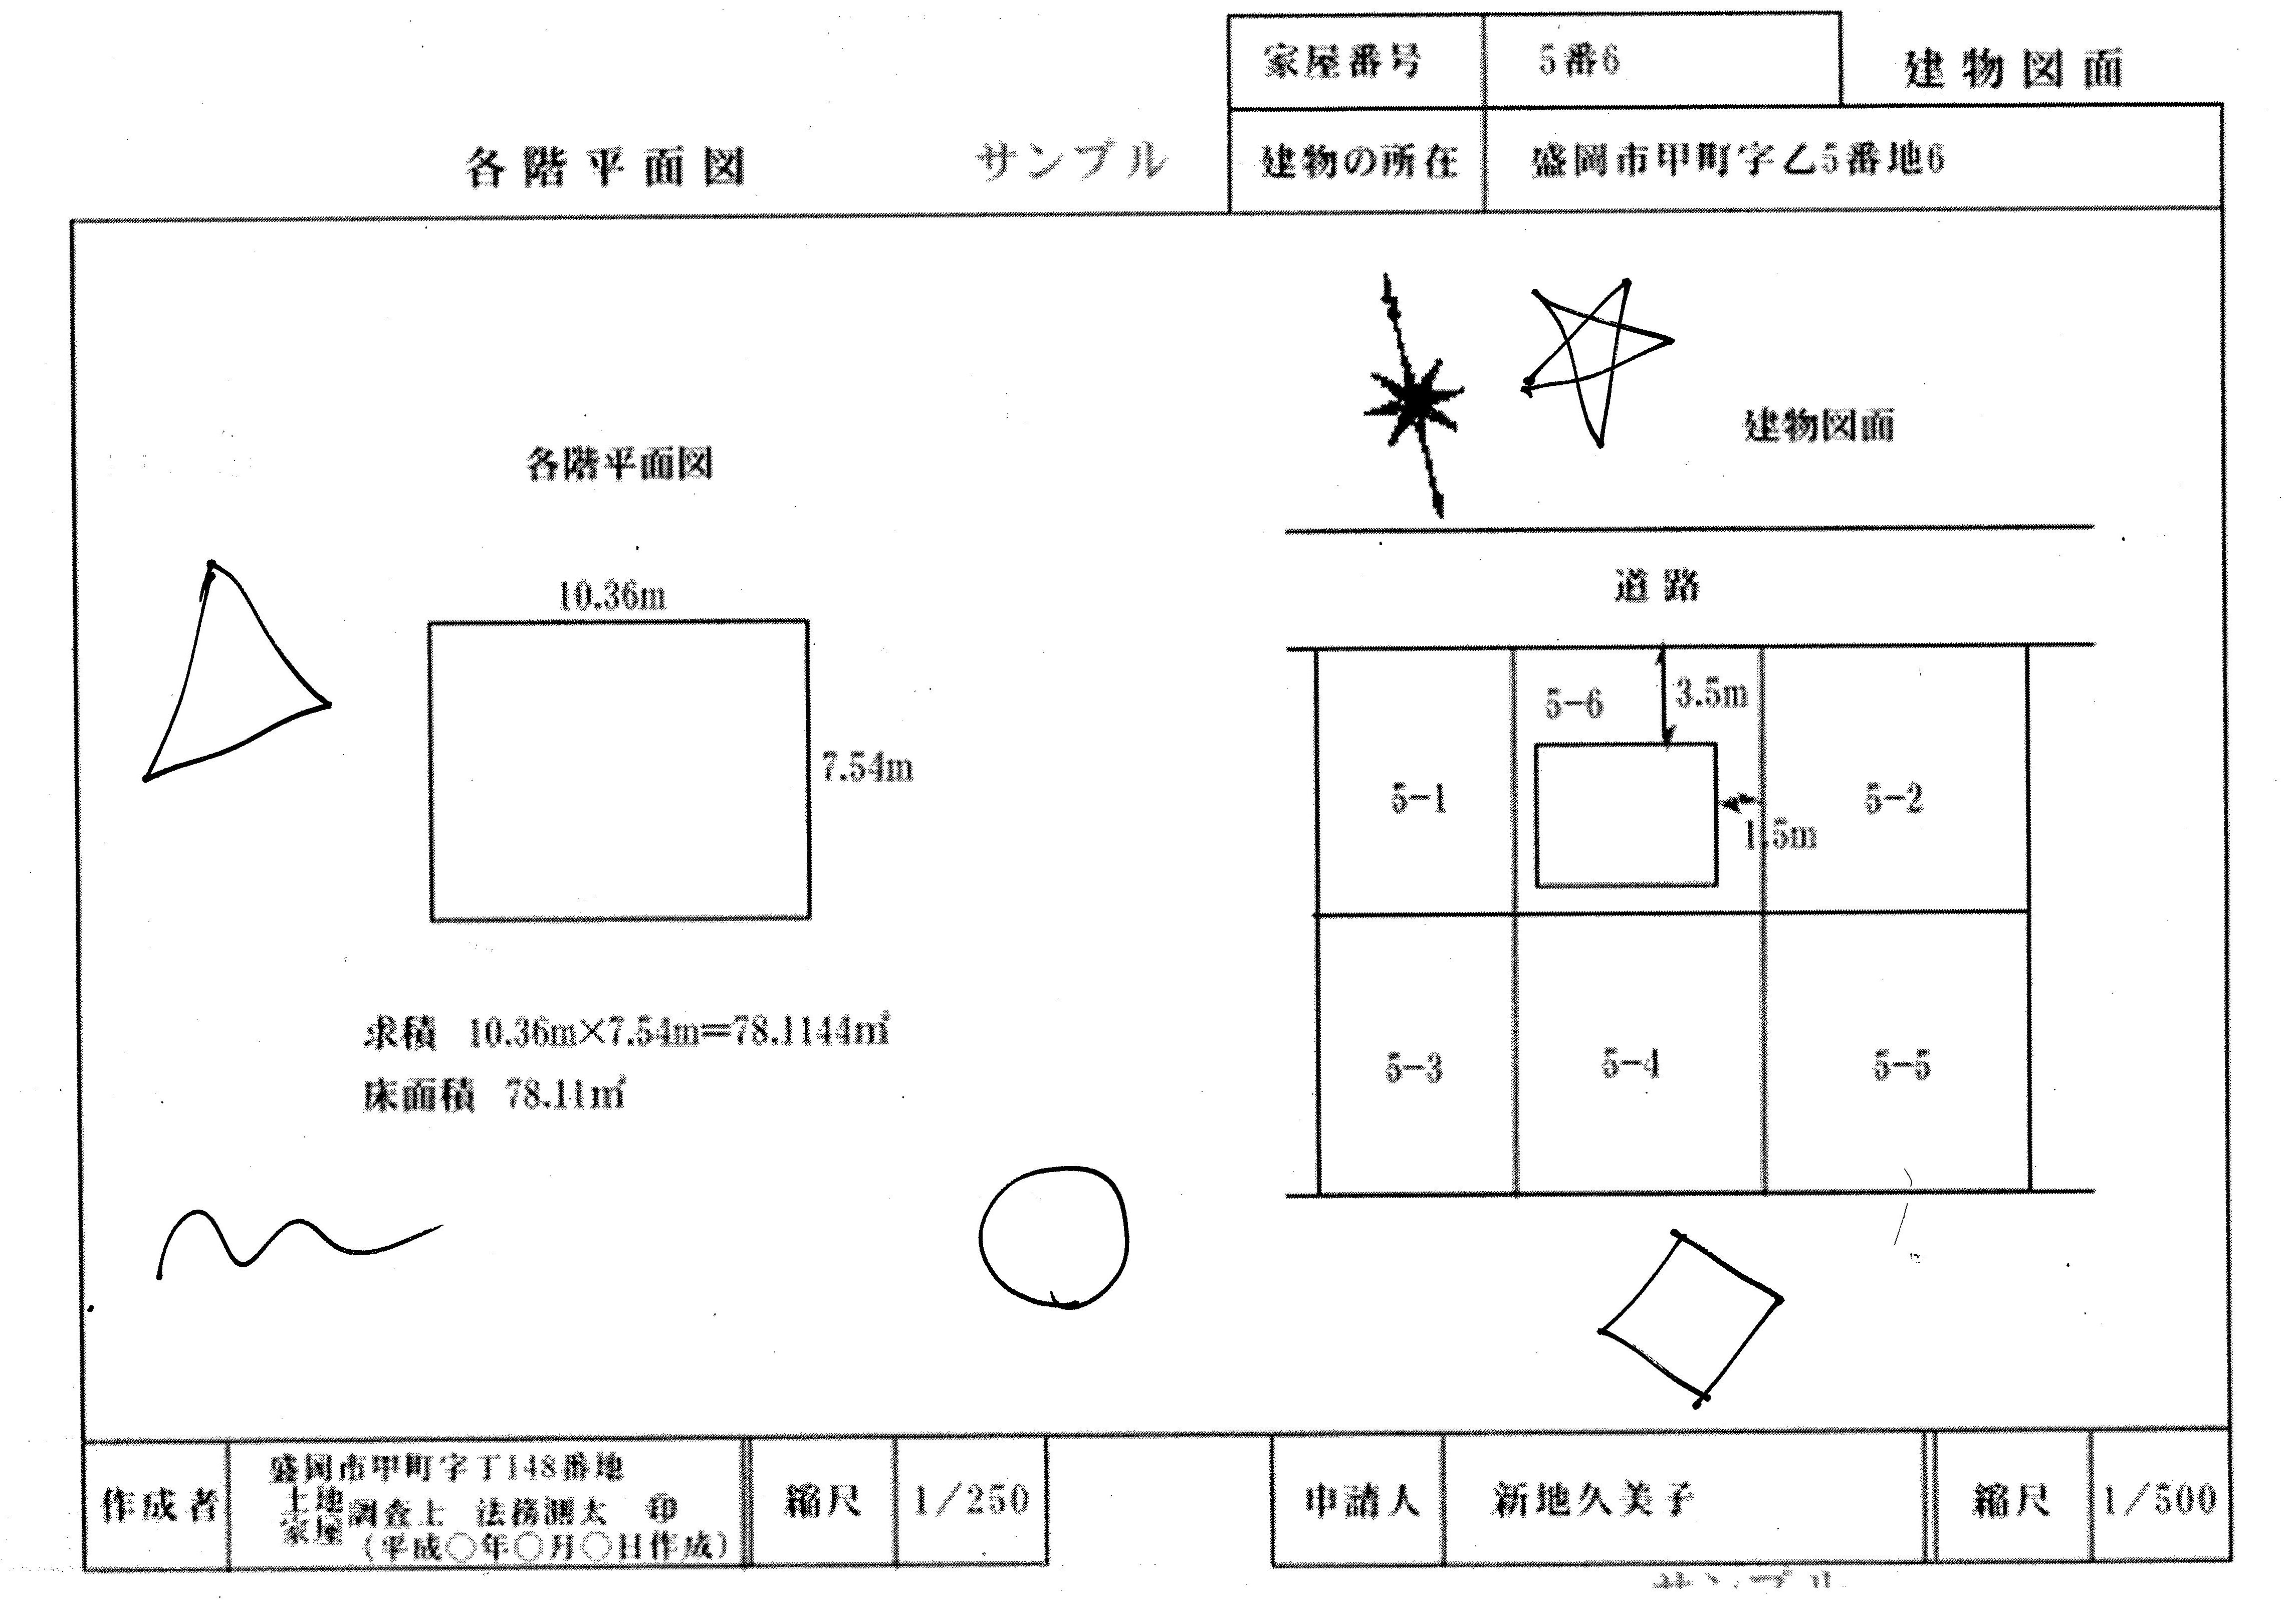

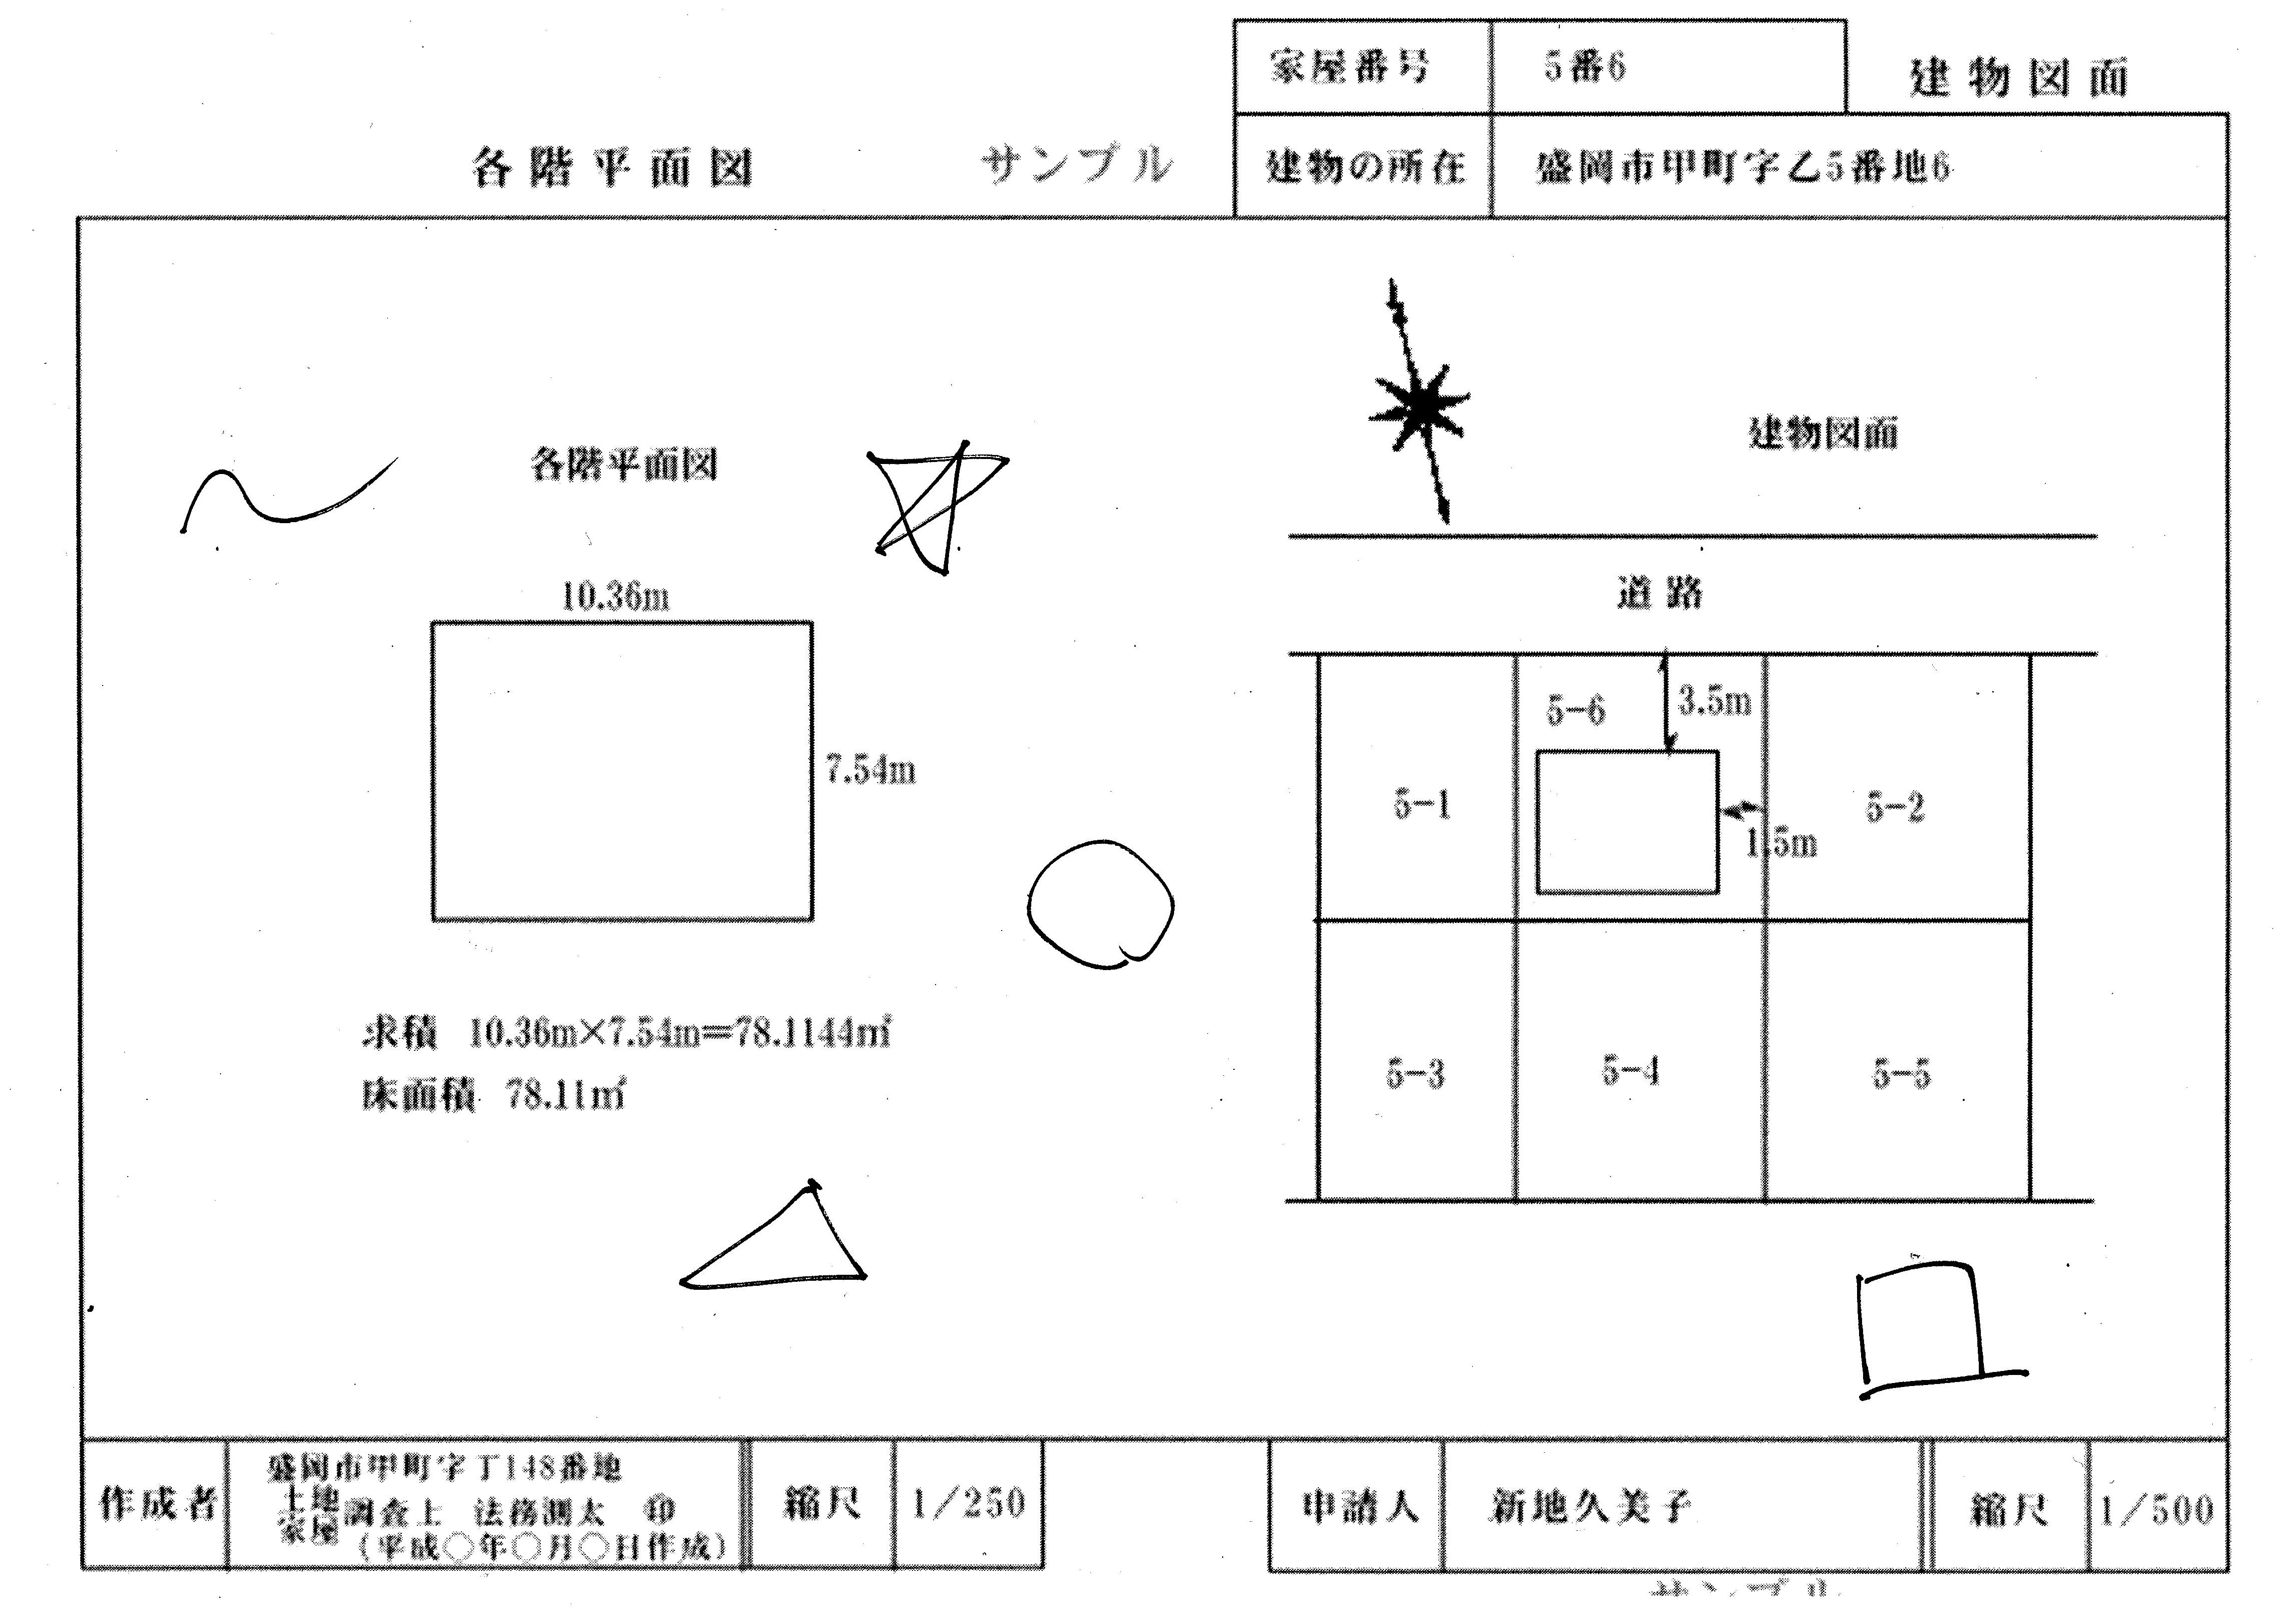

In [8]:
disp(fig1)
disp(fig2)

かんたんな平滑化

In [48]:
def blur(src, block=3) :
    dst = cv2.GaussianBlur(src, (block, block), 0)
    return dst

In [49]:
blur1 = blur(fig1)
blur2 = blur(fig2)

グレー画像に変換

In [50]:
def gray(src) :
    dst = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    return dst

In [51]:
gray1 = gray(blur1)
gray2 = gray(blur2)

中間調で二値化して、白黒反転

In [52]:
def bininv(src, thr=128) :
    dst = cv2.threshold(src, thr, 255, cv2.THRESH_BINARY_INV)
    return dst

In [53]:
inv1 = bininv(gray1)[1]
inv2 = bininv(gray2)[1]

ORBを用いてマッチング

In [54]:
def orbMatch(src, dst, max_pts=500, good_match_rate=0.15, min_match=10) :
    detector = cv2.ORB_create(max_pts)
    keyp1, dscr1 = detector.detectAndCompute(src, None)
    keyp2, dscr2 = detector.detectAndCompute(dst, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(dscr1, dscr2)
    matches = sorted(matches, key=lambda x:x.distance)
    good = matches[:int(len(matches)*good_match_rate)]
    matched_points = None
    #if len(good) > min_match:
    src_pts = np.float32([keyp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([keyp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    hmatrix, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)
    matched_mask = mask.ravel().tolist()
    ixs = np.where(np.asarray(matched_mask) == 1) 
    matched_src = src_pts[tuple([ix for ix in ixs])] 
    matched_dst = dst_pts[tuple([ix for ix in ixs])] 
    return hmatrix, matched_src, matched_dst

hmat : 画像2上の特徴点を画像1上の対応する特徴点位置に透視変換するマトリックス<BR>
matched : 画像2上の特徴点に対応する画像1上の特徴点座標

In [55]:
hmat, matched, _ = orbMatch(inv1, inv2, good_match_rate = 0.7)

透視変換

In [56]:
def transform(ref, src, matrix) :
    height = ref.shape[0]
    width = ref.shape[1]
    dst = cv2.warpPerspective(src, matrix, (width, height))
    return dst

In [57]:
inv2t = transform(inv1, inv2, hmat)

位置合わせ誤差を吸収するためにまず白線部分を膨張させた画像を作る

In [58]:
def dilate(src, block = 15) :
    elem = cv2.getStructuringElement(cv2.MORPH_CROSS,(block,block))
    dst = cv2.dilate(src, elem)
    return dst

In [59]:
dilate1 = dilate(inv1)
dilate2 = dilate(inv2t)

画像A-画像B<br>
　画像A：Blue:ゼロ値画像、Green:膨張させた画像1、Red:膨張させた画像2<BR>
　画像B：Blue:ゼロ値画像、Green:画像2、Red:画像1

In [60]:
def subtract(src1, src2, dilated1, dilated2) :
    a = src1.astype(np.uint8)
    b = src2.astype(np.uint8)
    c = dilated1.astype(np.uint8)
    d = dilated2.astype(np.uint8)
    e = np.zeros(src1.shape, np.uint8)
    p1 = np.dstack((e, a, b))
    p2 = np.dstack((e, d, c))
    dst = cv2.subtract(p1, p2)
    return dst

In [61]:
sub = subtract(inv1, inv2t, dilate1, dilate2)

差分画像を表示

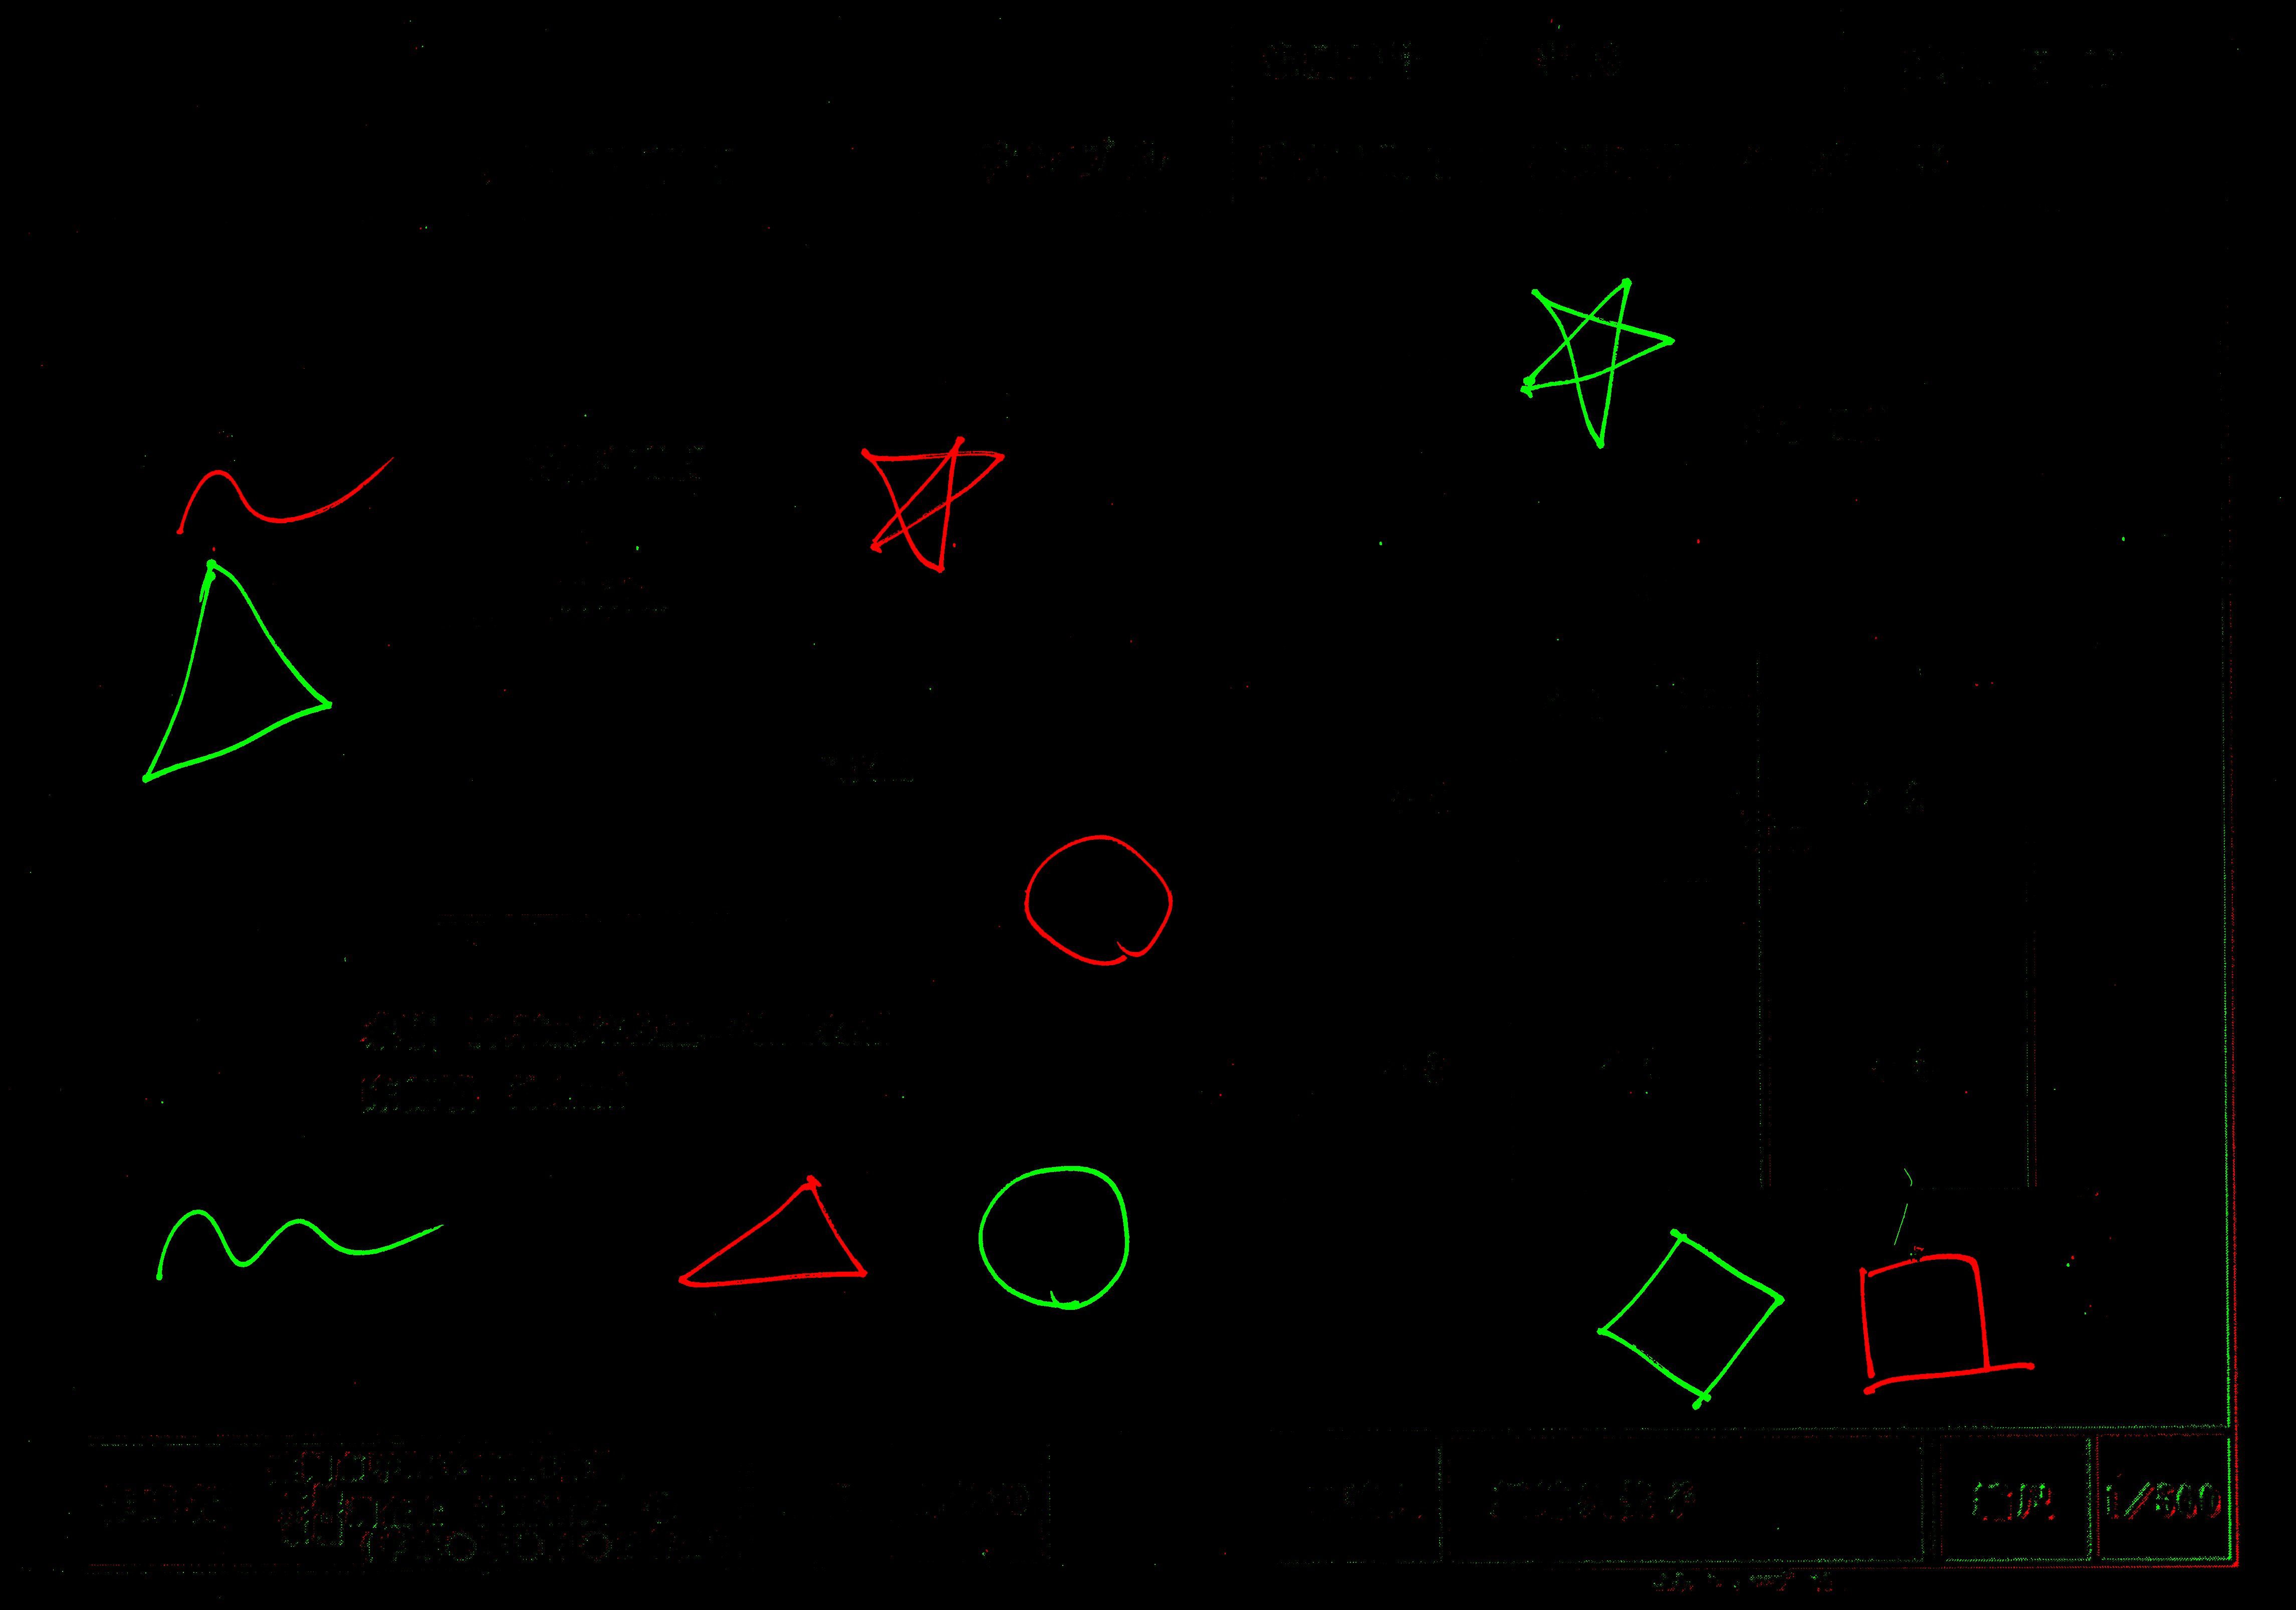

In [62]:
disp(sub)

上の差分画像を見ると、右下に位置合わせの不良が見えるので、<BR>
位置合わせに用いた特徴点（画像2上の特徴点に対応する画像1上の特徴点）を確認

In [63]:
def drawMatchedPoints(src, points, size=20, color=(255,0,0)) :
    dst = src.copy()
    for point in points :
        cv2.circle(dst, (int(point[0][0]), int(point[0][1])),
                   size, color, thickness=-1)
    return dst

In [64]:
tmp1 = drawMatchedPoints(sub, matched)

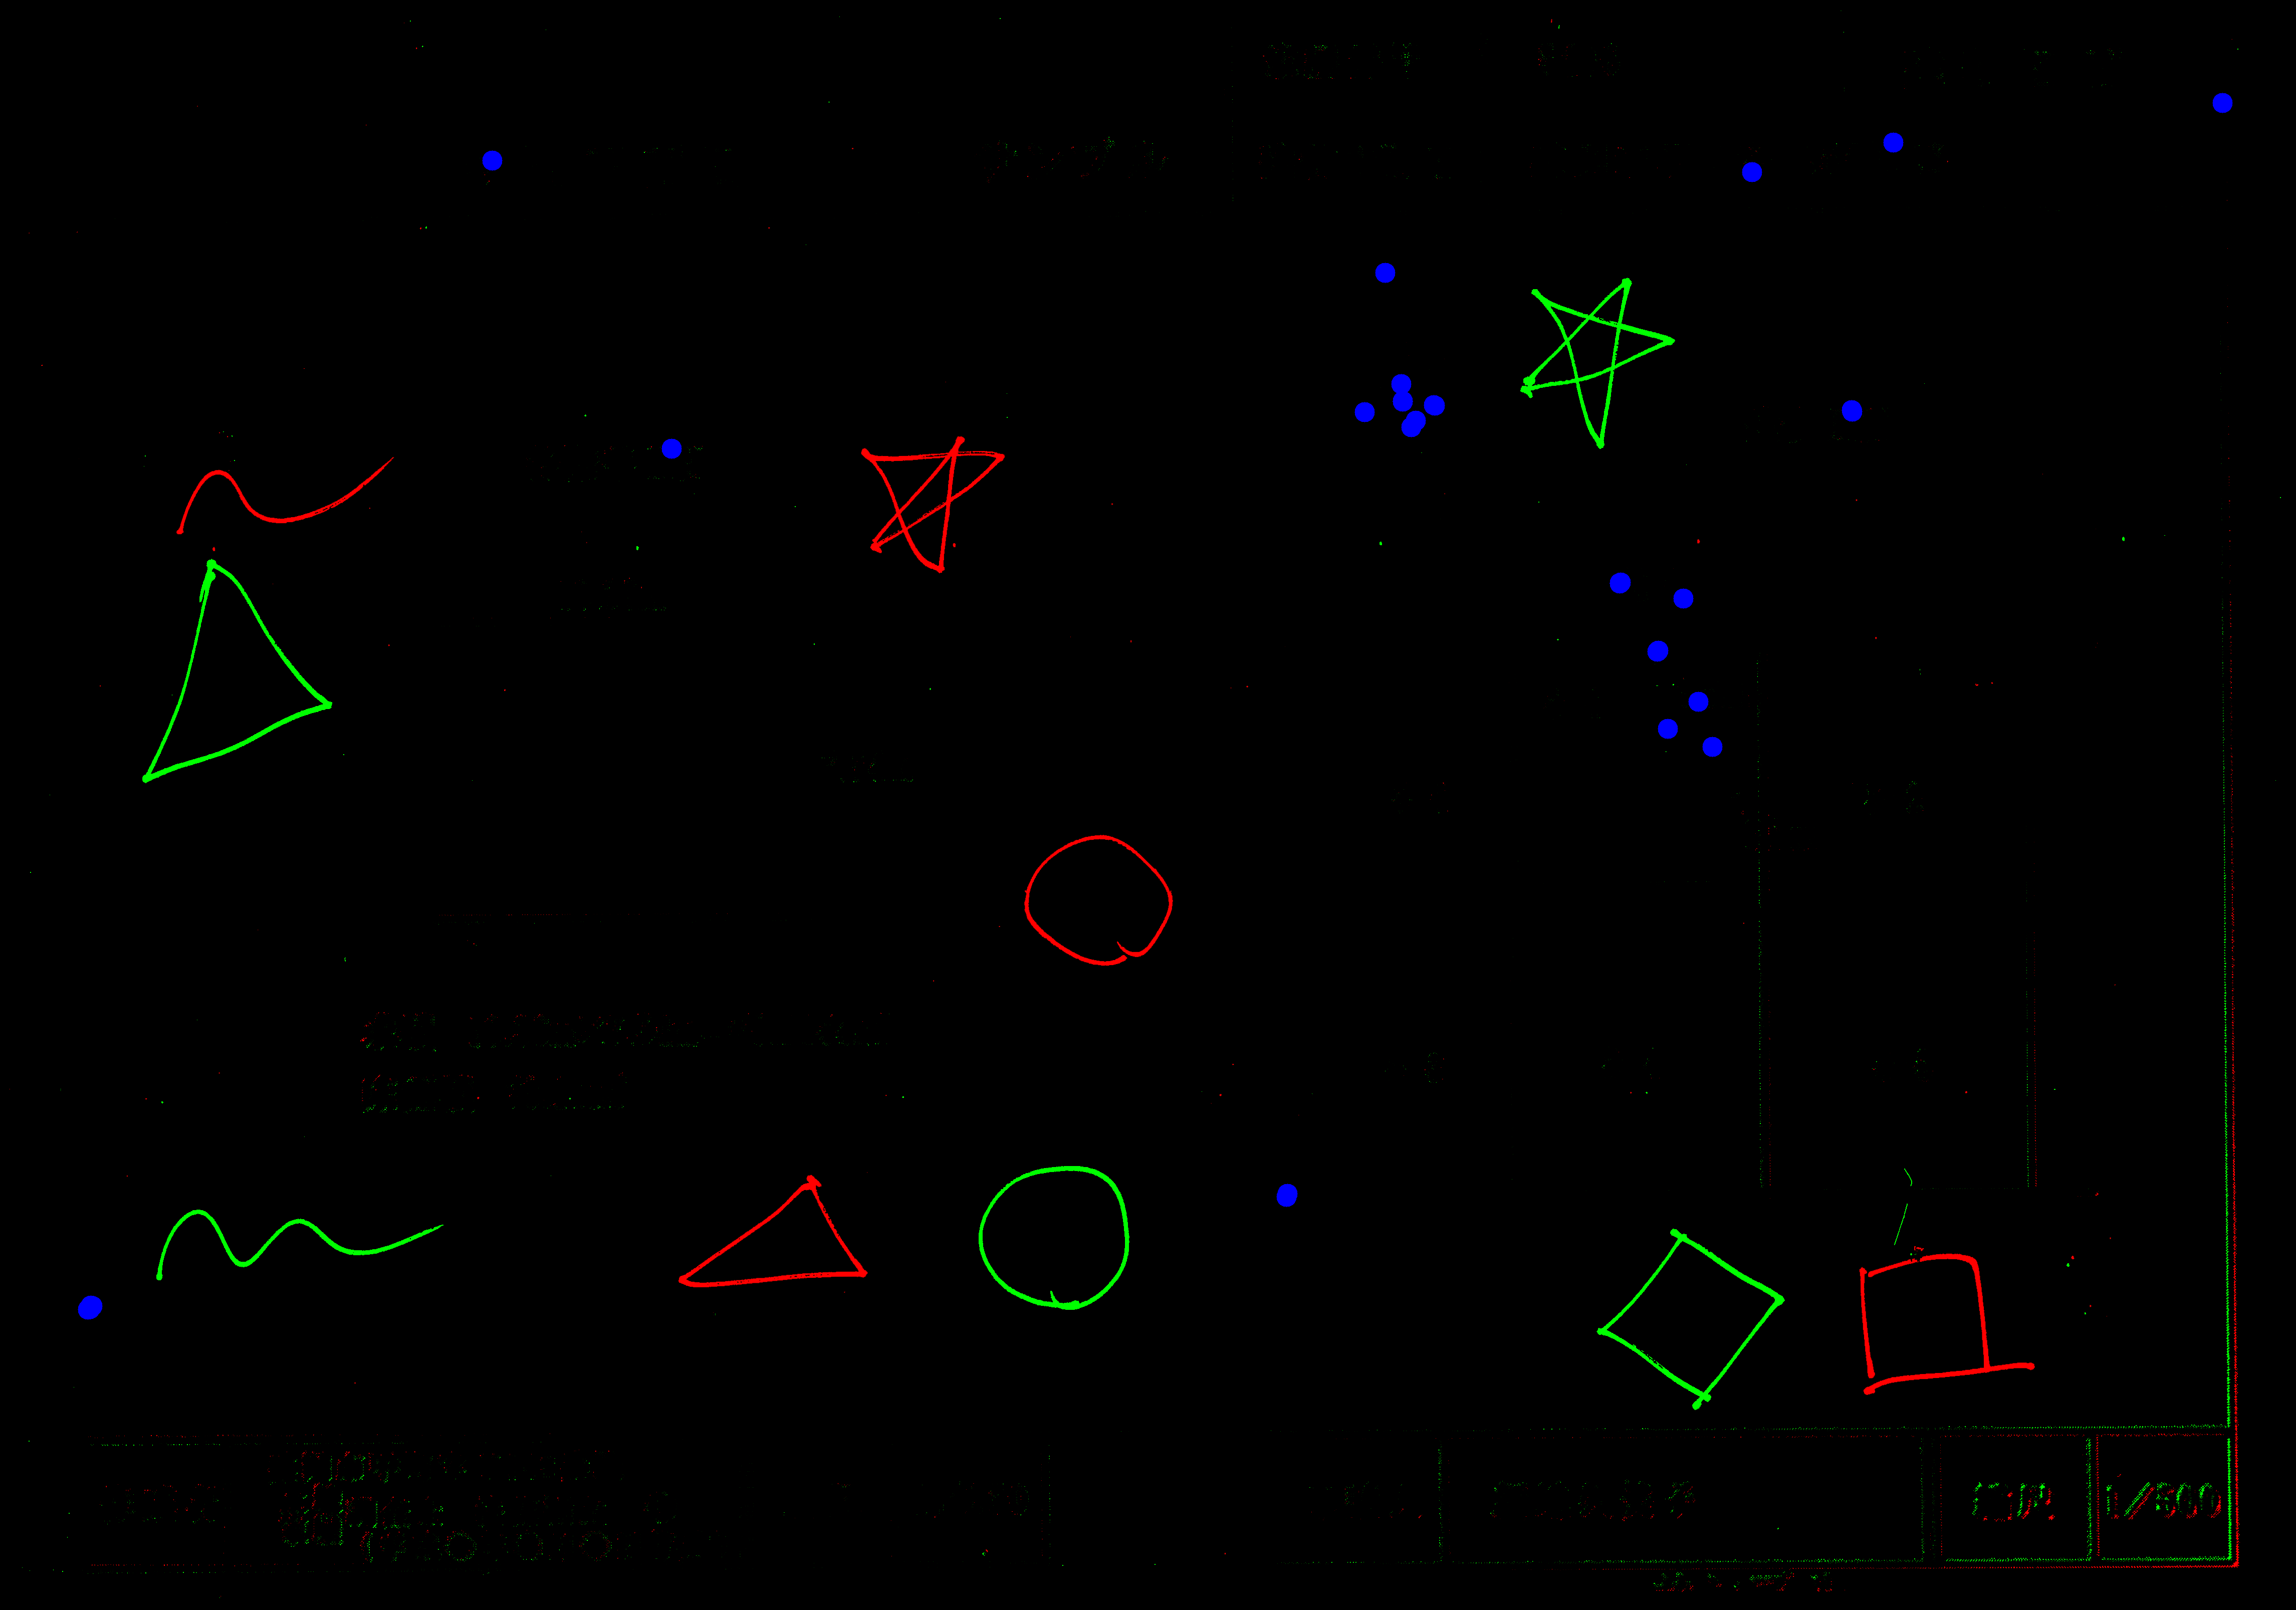

In [65]:
disp(tmp1)

上の画像を見ると、右下の方には位置合わせに使われている特徴点がない。<BR>
そこで、画像を縦横N分割して各部から位置合わせに用いる特徴を抽出し、ばらつきをなくす。

In [76]:
def align(src, dst, div=2, max_pts=500, good_match_rate=0.15, min_match=10) :
    height, width = src.shape[:2]
    deltah = height//div
    deltaw = width//div
    src_points = np.empty((0, 1, 2))
    dst_points = np.empty((0, 1, 2))
    for yix in range(div) :
        ys = yix * deltah
        ye = yix * deltah + deltah - 1
        for xix in range(div) :
            xs = xix * deltaw
            xe = xix * deltaw + deltaw - 1
            src_clip = src[ys:ye, xs:xe]
            dst_clip = dst[ys:ye, xs:xe]
            _, src_pts, dst_pts = orbMatch(src_clip, dst_clip,
                                          max_pts, good_match_rate, min_match)
            src_pts = src_pts + [xs, ys]
            dst_pts = dst_pts + [xs, ys]
            src_points = np.append(src_points, src_pts, axis = 0)
            dst_points = np.append(dst_points, dst_pts, axis = 0)
    hmatrix, mask = cv2.findHomography(dst_points, src_points, cv2.RANSAC)
    matched_mask = mask.ravel().tolist()
    ixs = np.where(np.asarray(matched_mask) == 1) 
    matched_src = src_points[tuple([ix for ix in ixs])] 
    matched_dst = dst_points[tuple([ix for ix in ixs])] 
    return hmatrix, matched_src, matched_dst

縦横２分割して、各領域から特徴点を抽出

In [67]:
hmat, matched, _ = align(inv1, inv2, div = 2, good_match_rate = 0.7)

In [68]:
inv2t = transform(inv1, inv2, hmat)

In [69]:
dilate1 = dilate(inv1)
dilate2 = dilate(inv2t)

In [70]:
sub = subtract(inv1, inv2t, dilate1, dilate2)

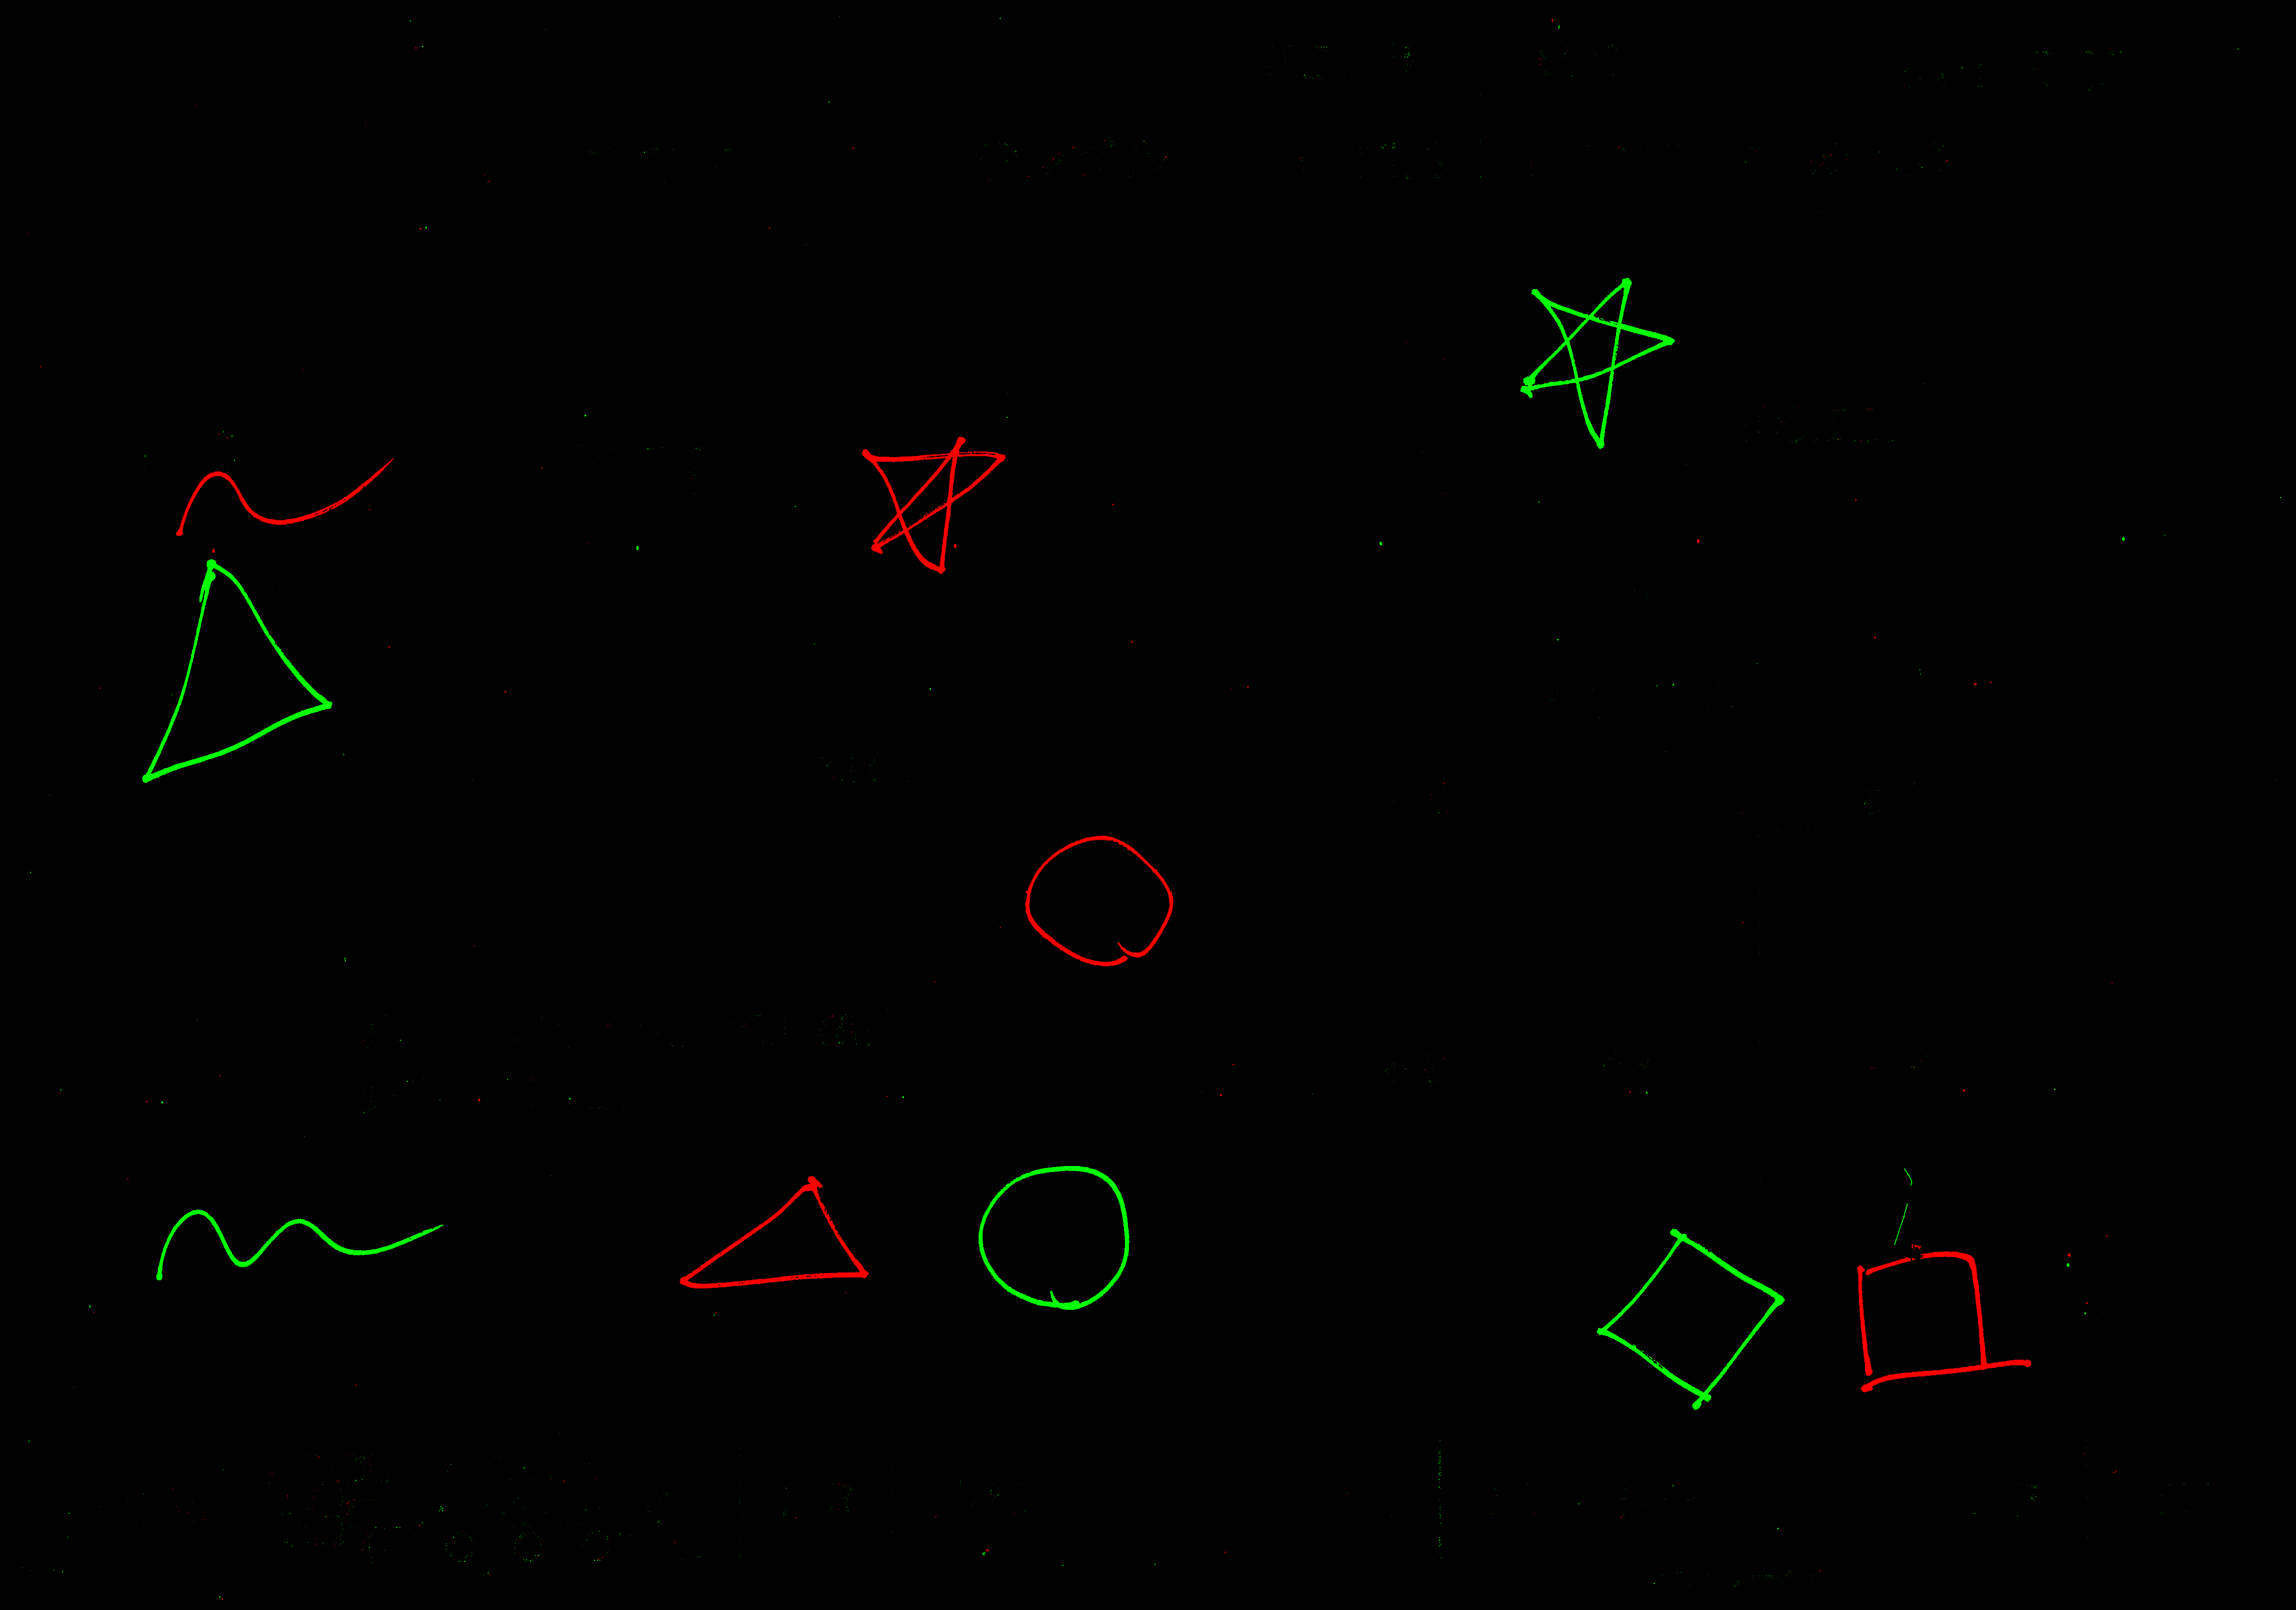

In [71]:
disp(sub)

右下の位置合わせ不良が解消されている。<BR>
位置合わせに用いた特徴点（画像2上の特徴点に対応する画像1上の特徴点）を確認

In [74]:
tmp = drawMatchedPoints(sub, matched)

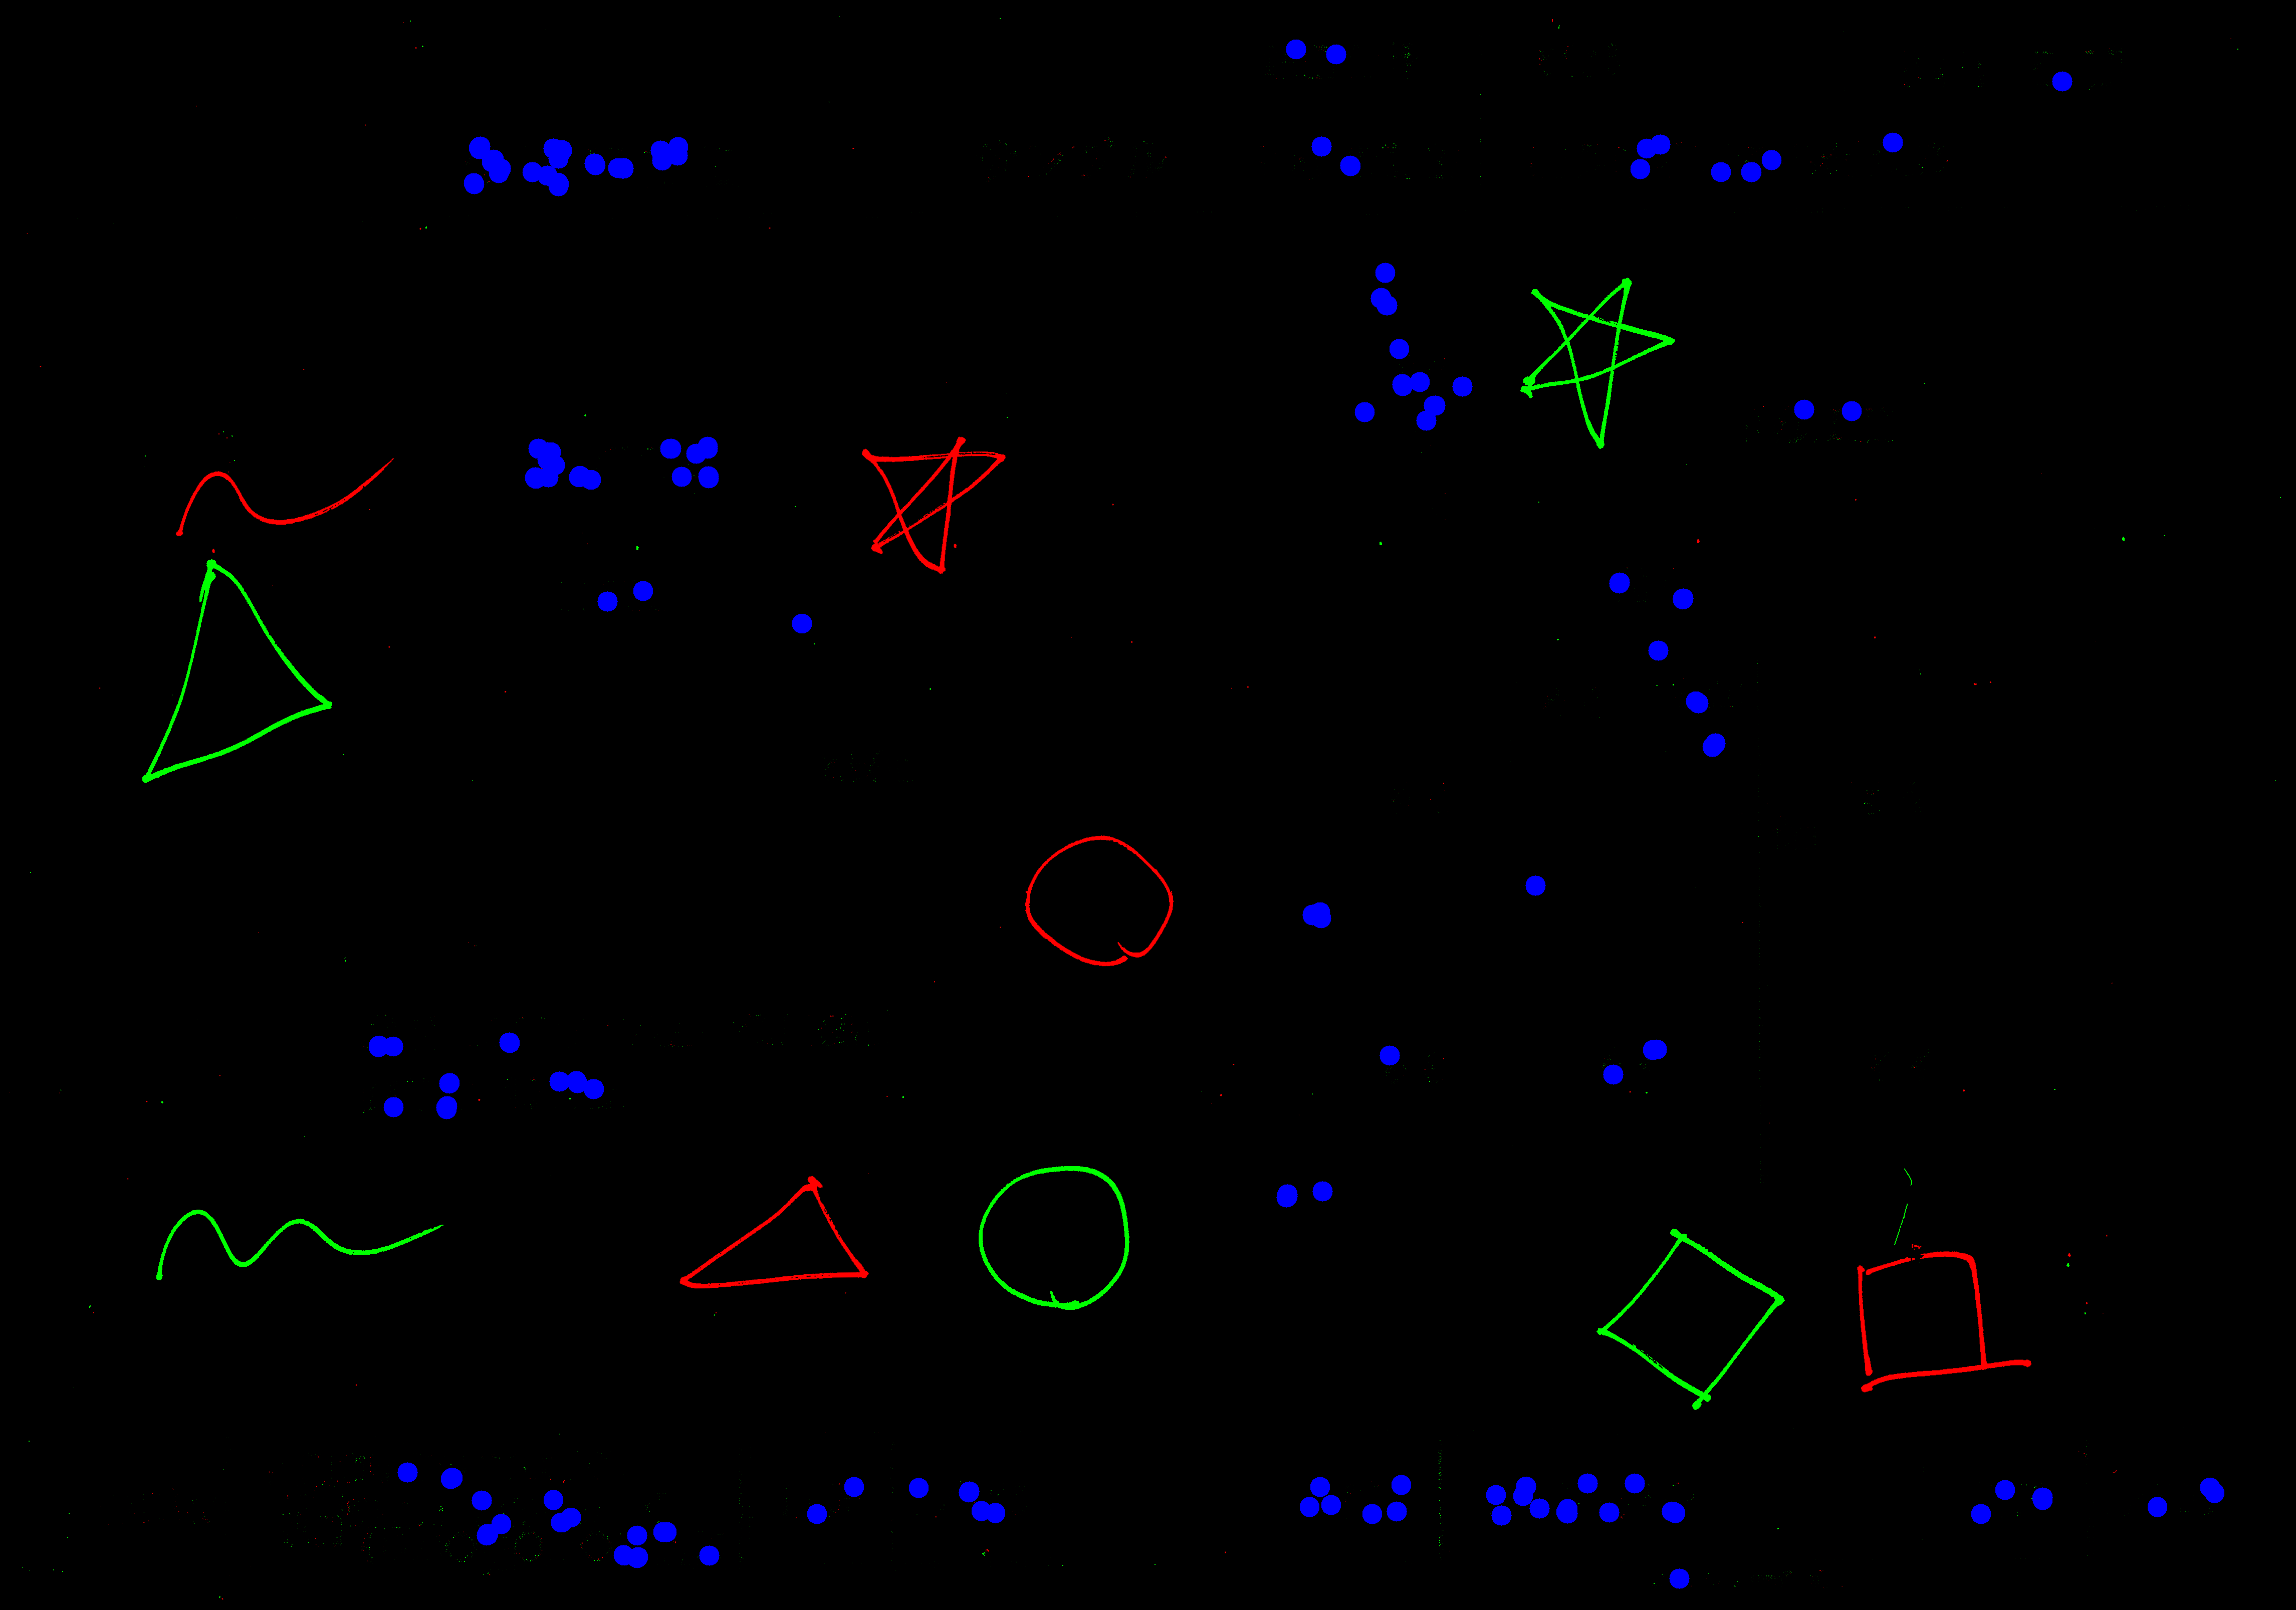

In [75]:
disp(tmp)

画像の全体からまんべんなく位置合わせ用の特徴点が抽出されている。